In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv('data.csv')
df

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1495,48,0,2,3,4,9.183783,66,3,80,3,1
1496,27,1,2,10,3,14.847731,43,97,7,2,0
1497,24,1,1,1,2,4.289911,31,91,58,1,1
1498,48,0,2,4,4,36.299263,9,37,44,2,1


In [5]:
df.info

<bound method DataFrame.info of       Age  Gender  EducationLevel  ExperienceYears  PreviousCompanies  \
0      26       1               2                0                  3   
1      39       1               4               12                  3   
2      48       0               2                3                  2   
3      34       1               2                5                  2   
4      30       0               1                6                  1   
...   ...     ...             ...              ...                ...   
1495   48       0               2                3                  4   
1496   27       1               2               10                  3   
1497   24       1               1                1                  2   
1498   48       0               2                4                  4   
1499   34       1               2               11                  5   

      DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
0               

In [6]:
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [15]:
df.isnull().sum()

Age                    0
Gender                 0
EducationLevel         0
ExperienceYears        0
PreviousCompanies      0
DistanceFromCompany    0
InterviewScore         0
SkillScore             0
PersonalityScore       0
RecruitmentStrategy    0
HiringDecision         0
dtype: int64

In [16]:
df.describe()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,35.148667,0.492000,2.188000,7.694000,3.00200,25.505379,50.564000,51.116000,49.387333,1.893333,0.310000
std,9.252728,0.500103,0.862449,4.641414,1.41067,14.567151,28.626215,29.353563,29.353201,0.689642,0.462647
min,20.000000,0.000000,1.000000,0.000000,1.00000,1.031376,0.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,0.000000,2.000000,4.000000,2.00000,12.838851,25.000000,25.750000,23.000000,1.000000,0.000000
50%,35.000000,0.000000,2.000000,8.000000,3.00000,25.502239,52.000000,53.000000,49.000000,2.000000,0.000000
75%,43.000000,1.000000,3.000000,12.000000,4.00000,37.737996,75.000000,76.000000,76.000000,2.000000,1.000000
max,50.000000,1.000000,4.000000,15.000000,5.00000,50.992462,100.000000,100.000000,100.000000,3.000000,1.000000


In [10]:
features = ['Age', 'Gender', 'EducationLevel', 'ExperienceYears', 'PreviousCompanies',
            'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'RecruitmentStrategy']
target = 'HiringDecision'

# === BIASED TRAIN-TEST SPLIT (80% Male in Train) ===
male_df = df[df['Gender'] == 1]
female_df = df[df['Gender'] == 0]

train_male = male_df.sample(frac=0.8, random_state=1)
train_female = female_df.sample(frac=0.2, random_state=1)
train_df = pd.concat([train_male, train_female])

test_df = df.drop(train_df.index)

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# === BASELINE MODEL ===
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Test Accuracy: {accuracy:.2f}")



Baseline Test Accuracy: 0.85


In [11]:
# === FAIRNESS METRICS ===
def get_fairness_metrics(X, y_true, y_pred):
    df_eval = X.copy()
    df_eval['y_true'] = y_true.values
    df_eval['y_pred'] = y_pred

    results = {}
    for group in [0, 1]:  # Female, Male
        group_data = df_eval[df_eval['Gender'] == group]
        y_g_true = group_data['y_true']
        y_g_pred = group_data['y_pred']

        tpr = ((y_g_pred == 1) & (y_g_true == 1)).sum() / max((y_g_true == 1).sum(), 1)
        fpr = ((y_g_pred == 1) & (y_g_true == 0)).sum() / max((y_g_true == 0).sum(), 1)
        pr = (y_g_pred == 1).mean()

        results['Male' if group == 1 else 'Female'] = {
            'TPR': tpr, 'FPR': fpr, 'DemographicParity': pr
        }

    avg_odds_diff = 0.5 * (
        abs(results['Male']['TPR'] - results['Female']['TPR']) +
        abs(results['Male']['FPR'] - results['Female']['FPR'])
    )

    return results, avg_odds_diff

fairness_metrics, avg_odds = get_fairness_metrics(X_test, y_test, y_pred)
print("\nFairness Metrics (Baseline):")
print(fairness_metrics)
print(f"Average Odds Difference: {avg_odds:.3f}")




Fairness Metrics (Baseline):
{'Female': {'TPR': np.float64(0.7202072538860104), 'FPR': np.float64(0.10071942446043165), 'DemographicParity': np.float64(0.2967213114754098)}, 'Male': {'TPR': np.float64(0.6486486486486487), 'FPR': np.float64(0.036036036036036036), 'DemographicParity': np.float64(0.1891891891891892)}}
Average Odds Difference: 0.068



SHAP Explanations:

--- Prediction 1 (Predicted: Hire) ---


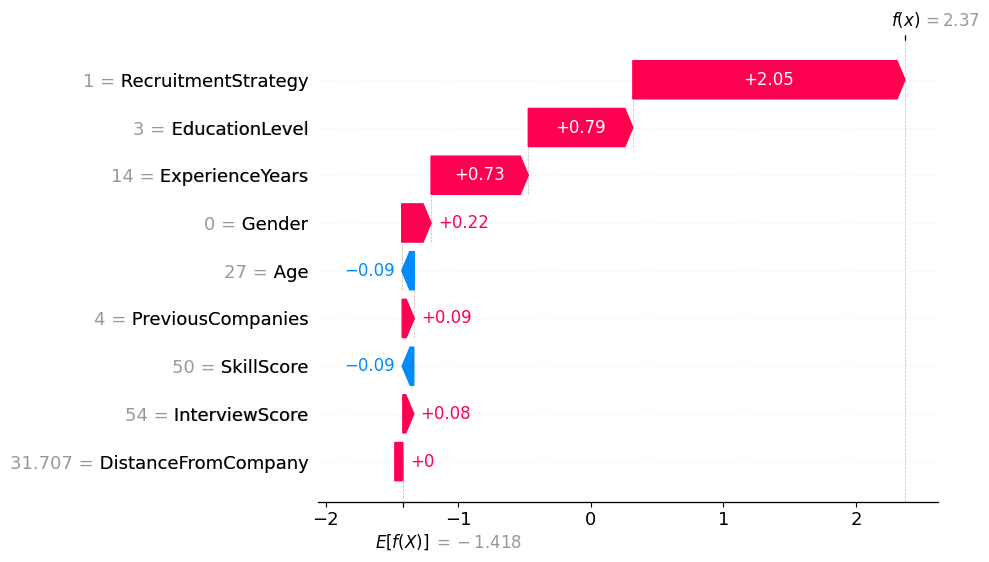


--- Prediction 3 (Predicted: Hire) ---


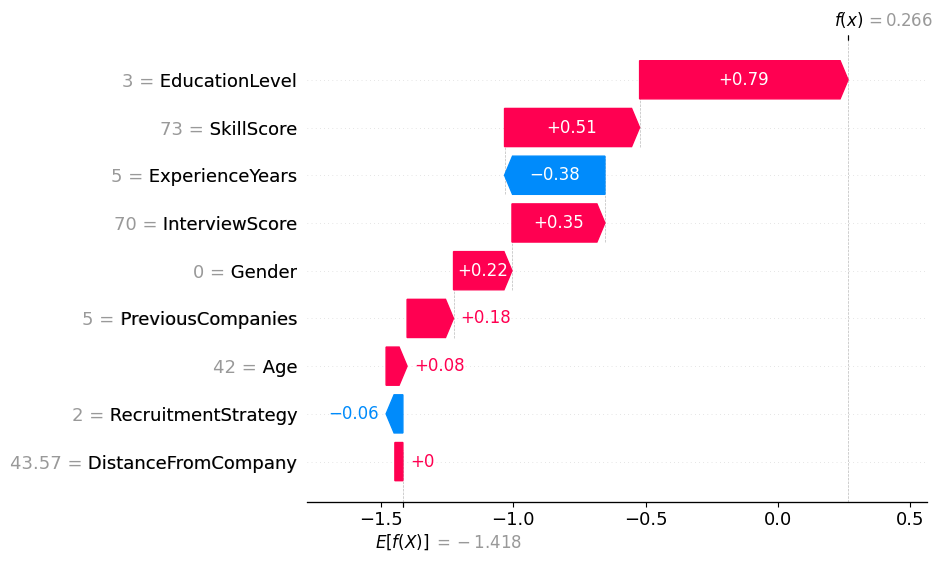


--- Prediction 20 (Predicted: Hire) ---


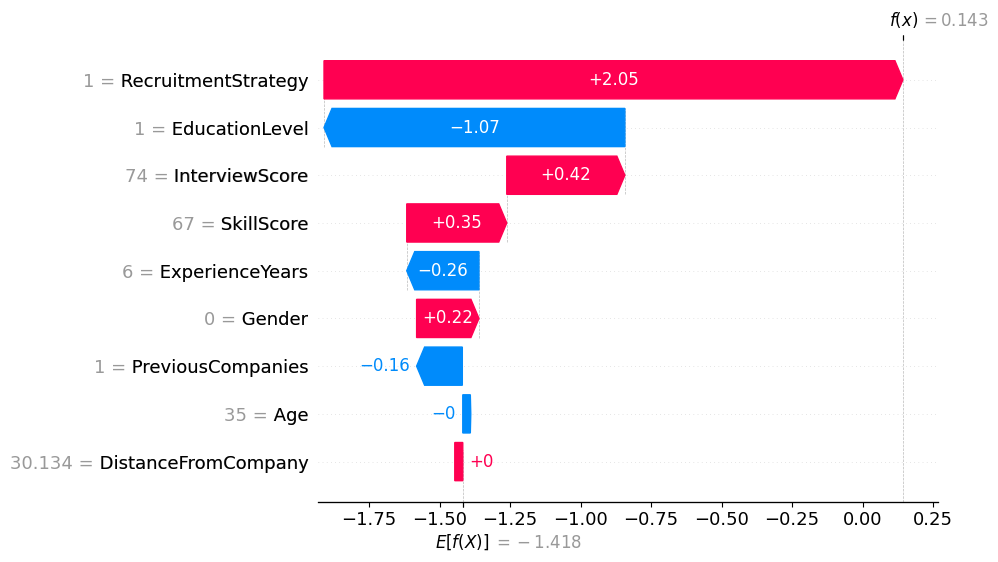


--- Prediction 0 (Predicted: No Hire) ---


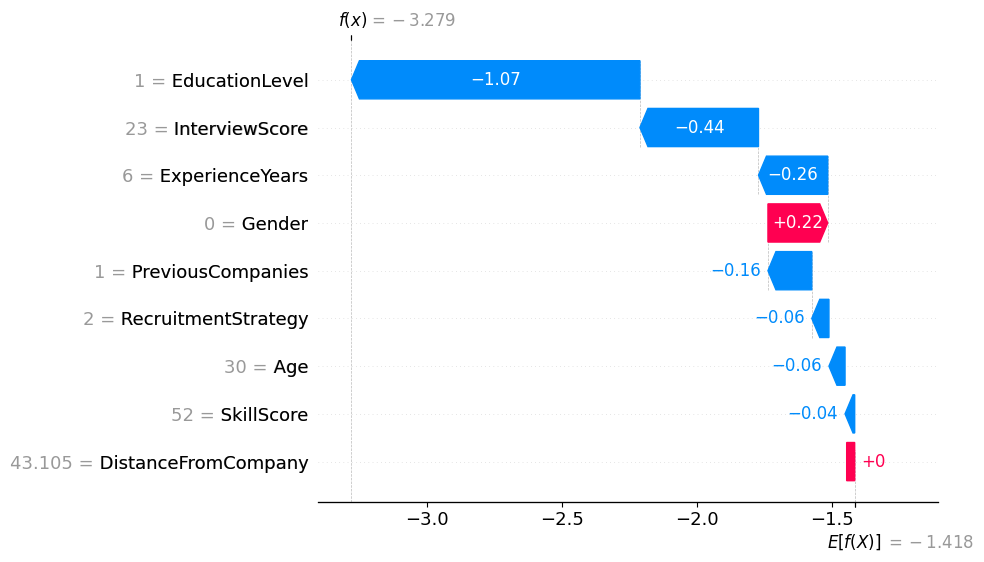


--- Prediction 2 (Predicted: No Hire) ---


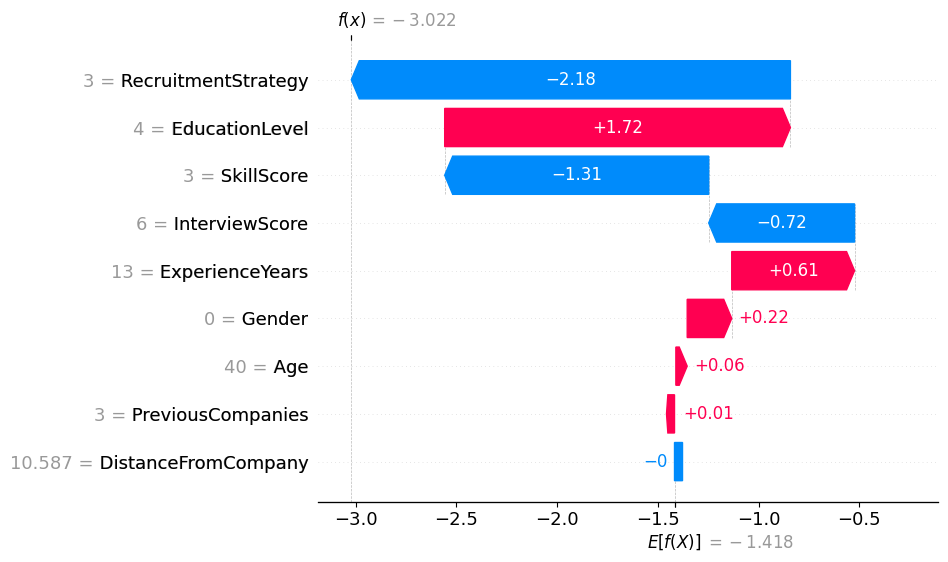

In [18]:
# === EXPLAINABILITY WITH SHAP ===
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

# Show 3 Hire and 2 No-Hire predictions
print("\nSHAP Explanations:")
hire_indices = np.where(y_pred == 1)[0][:3]
nohire_indices = np.where(y_pred == 0)[0][:2]

for idx in list(hire_indices) + list(nohire_indices):
    print(f"\n--- Prediction {idx} (Predicted: {'Hire' if y_pred[idx] == 1 else 'No Hire'}) ---")
    shap.plots.waterfall(shap_values[idx], max_display=10)



In [17]:
# === BIAS MITIGATION: REMOVE GENDER ===
X_train_mitigated = X_train.drop(columns=['Gender'])
X_test_mitigated = X_test.drop(columns=['Gender'])

clf_mitigated = LogisticRegression(max_iter=1000)
clf_mitigated.fit(X_train_mitigated, y_train)
y_pred_mitigated = clf_mitigated.predict(X_test_mitigated)
accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
print(f"\nMitigated Test Accuracy: {accuracy_mitigated:.2f}")

# === MITIGATED FAIRNESS METRICS ===
X_test_copy = X_test.copy()
X_test_copy['Gender'] = X_test['Gender']  # required for fairness metric
fairness_mitigated, avg_odds_mitigated = get_fairness_metrics(X_test_copy, y_test, y_pred_mitigated)
print("\nFairness Metrics (After Mitigation):")
print(fairness_mitigated)
print(f"Average Odds Difference (Mitigated): {avg_odds_mitigated:.3f}")


Mitigated Test Accuracy: 0.85

Fairness Metrics (After Mitigation):
{'Female': {'TPR': np.float64(0.6683937823834197), 'FPR': np.float64(0.07673860911270983), 'DemographicParity': np.float64(0.2639344262295082)}, 'Male': {'TPR': np.float64(0.6486486486486487), 'FPR': np.float64(0.036036036036036036), 'DemographicParity': np.float64(0.1891891891891892)}}
Average Odds Difference (Mitigated): 0.030
